# Chapter 6. Overfitting, Regularization, and Information Criteria

In [1]:
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from rethinking import (LM, MAP, coef, compare, ensemble, extract_samples,
                        link, precis, replicate)

### Code 6.1

In [2]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster",
            "sapiens"]
brainvolcc = torch.tensor([438., 452, 612, 521, 752, 871, 1350])
masskg = torch.tensor([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})

### Code 6.2

In [3]:
m6_1 = LM("brain ~ mass", data=d)
m6_1.model = pyro.do(m6_1.model, data={"sigma": 1})
m6_1.run();

### Code 6.3

In [4]:
resid = brainvolcc - (coef(m6_1)["Intercept"] + coef(m6_1)["mass"] * masskg)
1 - resid.var() / brainvolcc.var()

tensor(0.4902)

### Code 6.4

In [5]:
m6_2 = LM("brain ~ mass + I(mass ** 2)", data=d).run()

### Code 6.5

In [6]:
m6_3 = LM("brain ~ mass + I(mass ** 2) + I(mass ** 3)", data=d).run()
m6_4 = LM("brain ~ mass + I(mass ** 2) + I(mass ** 3) + I(mass ** 4)", data=d).run()
torch.set_default_dtype(torch.double)
m6_5 = LM("brain ~ mass + I(mass ** 2) + I(mass ** 3) + I(mass ** 4) "
          "+ I(mass ** 5)", data=d)
m6_5.model = pyro.do(m6_5.model, data={"sigma": 1})
m6_5.run()
m6_6 = LM("brain ~ mass + I(mass ** 2) + I(mass ** 3) + I(mass ** 4) "
          "+ I(mass ** 5) + I(mass ** 6)",
          data=d)
m6_6.model = pyro.do(m6_6.model, data={"sigma": 1})
m6_6.run()
torch.set_default_dtype(torch.float)

### Code 6.6

In [7]:
m6_7 = LM("brain ~ 1", data=d).run()

### Code 6.7

```python
d_new = d.drop(index=i)
d_new.index = range(d_new.shape[0])
```

### Code 6.8

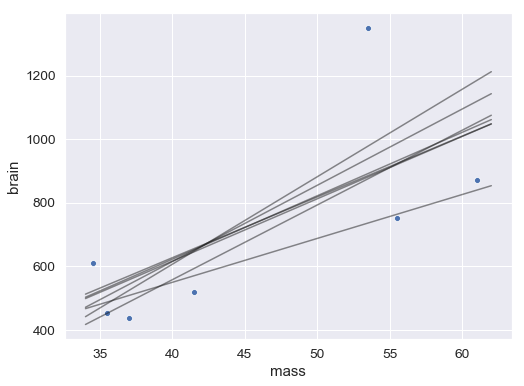

In [8]:
sns.scatterplot("mass", "brain", data=d)
for i in range(d.shape[0]):
    d_new = d.drop(index=i)
    d_new.index = range(d_new.shape[0])
    m0 = LM("brain ~ mass", data=d_new)
    m0.model = pyro.do(m0.model, data={"sigma": 1})
    m0.run()
    x = torch.linspace(34, 62, 101)
    sns.lineplot(x, coef(m0)["Intercept"] + coef(m0)["mass"] * x, color="k", alpha=0.5)

### Code 6.9

In [9]:
p = torch.tensor([0.3, 0.7])
-(p * p.log()).sum()

tensor(0.6109)

### Code 6.10

In [10]:
# fit model with lm
m6_1 = LM("brain ~ mass", data=d).run()
m6_1.model = pyro.do(m6_1.model, data={"sigma": 1})
m6_1.run()

# compute deviance by cheating
coefs = coef(m6_1)
resid = brainvolcc - (coefs["Intercept"] + coefs["mass"] * masskg)
sigma = resid.pow(2).mean().sqrt()
coefs["sigma"] = sigma
model = pyro.do(LM("brain ~ mass", data=d, centering=False).model, data=coefs)
(-2) * pyro.poutine.trace(model).get_trace().log_prob_sum()

tensor(94.9250)

### Code 6.11

In [11]:
# standardize the mass before fitting
mass_s = (masskg - masskg.mean()) / masskg.std()

def model(mass, brain):
    a = pyro.param("a", brainvolcc.mean())
    b = pyro.param("b", torch.tensor(0.))
    mu = a + b * mass
    sigma = pyro.param("sigma", brainvolcc.std(), constraints.positive)
    with pyro.plate("plate"):
        pyro.sample("brain", dist.Normal(mu, sigma), obs=brain)

m6_8 = MAP(model).run(mass_s, brainvolcc)

# extract MAP estimates
theta = list(coef(m6_8).values())

# compute deviance
dev = (-2) * dist.Normal(theta[0] + theta[1] * mass_s,
                         theta[2]).log_prob(brainvolcc).sum()
dev

tensor(94.9536)

### Code 6.12

In [12]:
def model(mm, y, b_sigma):
        a = pyro.param("a", torch.tensor(0.))
        Bvec = a.unsqueeze(0)
        k = mm.size(1)
        if k > 1:
            with pyro.plate("plate_b", k - 1):
                b = pyro.sample("b", dist.Normal(0, b_sigma))
            Bvec = torch.cat([Bvec, b])
        mu = mm.matmul(Bvec)
        with pyro.plate("plate"):
            pyro.sample("y", dist.Normal(mu, 1), obs=y)

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    n_dim = max(k, 3)
    Rho = torch.eye(n_dim)
    Rho[1:len(rho) + 1, 0] = torch.tensor(rho)
    Rho[0, 1:len(rho) + 1] = torch.tensor(rho)

    X_train = dist.MultivariateNormal(torch.zeros(n_dim), Rho).sample(torch.Size([N]))
    mm_train = torch.ones(N, 1)
    if k > 1:
        mm_train = torch.cat([mm_train, X_train[:, 1:k]], dim=1)

    m = MAP(model, start={"b": torch.zeros(k - 1)}, num_samples=10)
    m.run(mm_train, X_train[:, 0], b_sigma)
    coefs = torch.cat([c.reshape(-1) for c in coef(m).values()])
    dev_train = (-2) * dist.Normal(mm_train.matmul(coefs),
                                   1).log_prob(X_train[:, 0]).sum()

    X_test = dist.MultivariateNormal(torch.zeros(n_dim), Rho).sample(torch.Size([N]))
    mm_test = torch.ones(N, 1)
    if k > 1:
        mm_test = torch.cat([mm_test, X_test[:, 1:k]], dim=1)
    dev_test = (-2) * dist.Normal(mm_test.matmul(coefs),
                                  1).log_prob(X_test[:, 0]).sum()
    return torch.stack([dev_train, dev_test])

def dev_fn(N, k):
    print(k)
    r = torch.stack(replicate(int(1e4), sim_train_test, (N, k)), dim=1)
    return torch.stack([r[0].mean(), r[1].mean(), r[0].std(), r[1].std()])

N = 20
kseq = range(1, 6)
dev = torch.stack([dev_fn(N, k) for k in kseq], dim=1)

1
2
3
4
5


### Code 6.13

```python
r = torch.stack(replicate(int(1e4), sim_train_test, (N, k), mc_cores=4), dim=1)
```

### Code 6.14

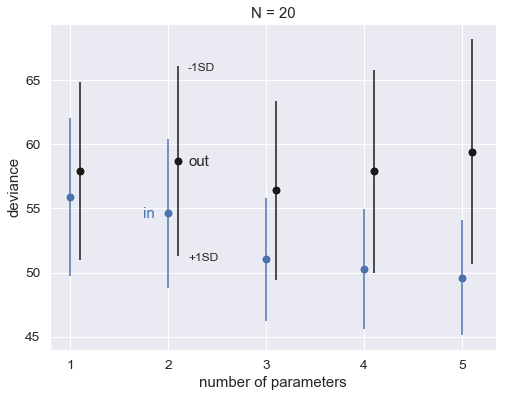

In [13]:
ax = sns.scatterplot(torch.arange(1, 6), dev[0], s=80, color="b")
ax.set(xlabel="number of parameters", ylabel="deviance", title="N = {}".format(N))
sns.scatterplot(torch.arange(1.1, 6), dev[1], s=80, color="k")
pts_int = (dev[0] - dev[2], dev[0] + dev[2])
pts_out = (dev[1] - dev[3], dev[1] + dev[3])
ax.vlines(torch.arange(1, 6), pts_int[0], pts_int[1], color="b")
ax.vlines(torch.arange(1.1, 6), pts_out[0], pts_out[1], color="k")
ax.annotate("in", (2, dev[0][1]), xytext=(-25, -5),
            textcoords="offset pixels", color="b")
ax.annotate("out", (2.1, dev[1][1]), xytext=(10, -5), textcoords="offset pixels")
ax.annotate("-1SD", (2.1, pts_out[1][1]), xytext=(10, -5),
            textcoords="offset pixels", fontsize=12)
ax.annotate("+1SD", (2.1, pts_out[0][1]), xytext=(10, -5),
            textcoords="offset pixels", fontsize=12);

### Code 6.15

In [14]:
cars = pd.read_csv("../data/cars.csv", sep=",")
speed = torch.tensor(cars["speed"], dtype=torch.float)
distance = torch.tensor(cars["dist"], dtype=torch.float)

def model(speed, distance):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    mu = a + b * speed
    sigma = pyro.sample("sigma", dist.Uniform(0, 30))
    with pyro.plate("plate"):
        pyro.sample("dist", dist.Normal(mu, sigma), obs=distance)

m = MAP(model).run(speed, distance)
idx = m._categorical.sample(torch.Size([1000]))
post = {latent: samples[idx] for latent, samples in extract_samples(m).items()}

### Code 6.16

In [15]:
n_samples = 1000

def ll_fn(s):
    mu = post["a"][s] + post["b"][s] * speed
    return dist.Normal(mu, post["sigma"][s]).log_prob(distance)

ll = torch.stack([ll_fn(s) for s in range(n_samples)], dim=1)

### Code 6.17

In [16]:
n_cases = cars.shape[0]
lppd = ll.logsumexp(1) - torch.tensor(float(n_samples)).log()

### Code 6.18

In [17]:
pWAIC = ll.var(1)

### Code 6.19

In [18]:
-2 * (lppd.sum() - pWAIC.sum())

tensor(421.0318)

### Code 6.20

In [19]:
waic_vec = -2 * (lppd - pWAIC)
(n_cases * waic_vec.var()).sqrt()

tensor(14.3545)

### Code 6.21

In [20]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk.dropna().copy()
d["neocortex"] = d["neocortex.perc"] / 100
d.shape

(17, 9)

### Code 6.22

In [21]:
kcal_per_g = torch.tensor(d["kcal.per.g"], dtype=torch.float)
a_start = kcal_per_g.mean()
sigma_start = kcal_per_g.std().log()

def model(kcal_per_g):
    a = pyro.param("a", a_start)
    log_sigma = pyro.param("log.sigma", sigma_start)
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(a, log_sigma.exp()), obs=kcal_per_g)

m6_11 = MAP(model).run(kcal_per_g)

def model(neocortex, kcal_per_g):
    a = pyro.param("a", a_start)
    bn = pyro.param("bn", torch.tensor(0.))
    mu = a + bn * neocortex
    log_sigma = pyro.param("log.sigma", sigma_start)
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

neocortex = torch.tensor(d["neocortex"], dtype=torch.float)
m6_12 = MAP(model).run(neocortex, kcal_per_g)

def model(mass, kcal_per_g):
    a = pyro.param("a", a_start)
    bm = pyro.param("bm", torch.tensor(0.))
    mu = a + bm * mass.log()
    log_sigma = pyro.param("log.sigma", sigma_start)
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

mass = torch.tensor(d["mass"], dtype=torch.float)
m6_13 = MAP(model).run(mass, kcal_per_g)

def model(neocortex, mass, kcal_per_g):
    a = pyro.param("a", a_start)
    bn = pyro.param("bn", torch.tensor(0.))
    bm = pyro.param("bm", torch.tensor(0.))
    mu = a + bn * neocortex + bm * mass.log()
    log_sigma = pyro.param("log.sigma", sigma_start)
    with pyro.plate("plate"):
        pyro.sample("kcal.per.g", dist.Normal(mu, log_sigma.exp()), obs=kcal_per_g)

m6_14 = MAP(model).run(neocortex, mass, kcal_per_g)

### Code 6.23

In [22]:
with torch.no_grad():
    print(m6_14.information_criterion())

OrderedDict([('waic', tensor(-15.1608)), ('p_waic', tensor(4.7740))])


### Code 6.24

In [23]:
milk_models = compare({"m6.11": m6_11, "m6.12": m6_12, "m6.13": m6_13, "m6.14": m6_14})
milk_models.round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
m6.14,-15.16,4.77,0.00,0.93,7.73,0.00
m6.11,-8.22,1.85,6.94,0.03,4.67,7.23
m6.13,-8.01,2.97,7.16,0.03,5.81,5.26
m6.12,-6.45,2.79,8.71,0.01,4.37,7.52


### Code 6.25

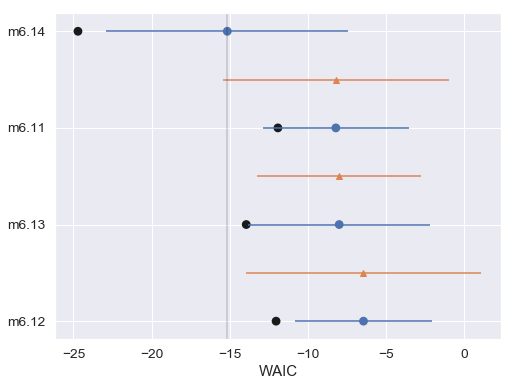

In [24]:
ax = sns.pointplot(milk_models["WAIC"], milk_models.index, join=False)
ax.errorbar(milk_models["WAIC"], milk_models.index, xerr=milk_models["SE"], fmt="none")
sns.pointplot(milk_models["WAIC"] - 2 * milk_models["pWAIC"],
              milk_models.index, color="k", join=False)
ax.errorbar(milk_models["WAIC"][1:], [0.5, 1.5, 2.5],
            xerr=milk_models["dSE"][1:], fmt="^")
ax.axvline(milk_models["WAIC"][0], c="k", alpha=0.2)
ax.yaxis.grid(True)

### Code 6.26

In [25]:
dWAIC = milk_models.loc["m6.11", "dWAIC"]
dSE = milk_models.loc["m6.11", "dSE"]
diff = torch.empty(int(1e5)).normal_(dWAIC, dSE)
(diff < 0).float().sum() / 1e5

tensor(0.1719)

### Code 6.27

In [26]:
pd.concat([precis(m6_11), precis(m6_12), precis(m6_13), precis(m6_14)],
           keys=["m6.11", "m6.12", "m6.13", "m6.14"]).unstack(level=0)["Mean"]

,m6.11,m6.12,m6.13,m6.14
a,0.66,0.35,0.71,-1.09
bm,NaN,NaN,-0.03,-0.10
bn,NaN,0.45,NaN,2.80
log.sigma,-1.78,-1.79,-1.85,-2.17


### Code 6.28

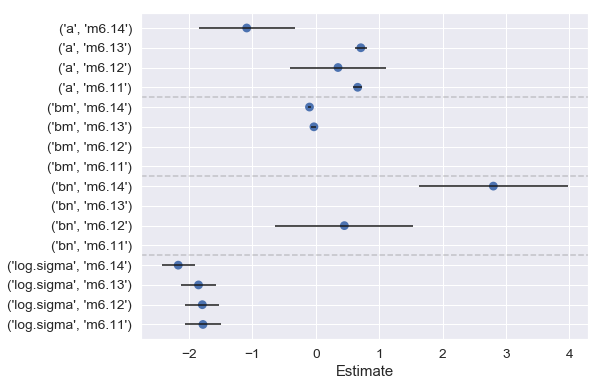

In [27]:
coeftab = pd.concat([precis(m6_11), precis(m6_12), precis(m6_13), precis(m6_14)],
                    keys=["m6.11", "m6.12", "m6.13", "m6.14"]).unstack(level=0)
mean = coeftab["Mean"].iloc[:, ::-1].stack(dropna=False)
error = mean - coeftab["|0.89"].iloc[:, ::-1].stack(dropna=False)
ax = sns.pointplot(mean, mean.index, join=False, facecolors="none")
ax.errorbar(mean, range(mean.shape[0]), xerr=error, fmt="none", c="k")
ax.set(xlabel="Estimate")
for i in range(1, coeftab.shape[0]):
    ax.axhline(i * coeftab["Mean"].shape[1] - 0.5, c="k", alpha=0.2, linestyle="--")
ax.yaxis.grid(True)

### Code 6.29

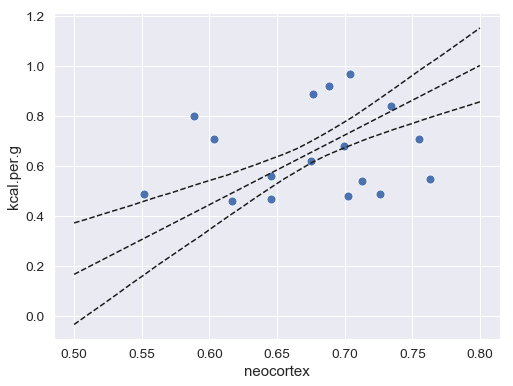

In [28]:
# compute counterfactual predictions
# neocortex from 0.5 to 0.8
nc_seq = torch.linspace(start=0.5, end=0.8, steps=30)
d_predict = {
    "kcal_per_g": None,  # empty outcome
    "neocortex": nc_seq,  # sequence of neocortex
    "mass": torch.tensor(4.5).repeat(30)  # average mass
}
pred_m6_14 = link(m6_14, data=d_predict)
mu = pred_m6_14.mean(0)
mu_PI = stats.pi(pred_m6_14, 0.89, dim=0)

# plot it all
fig, ax = sns.mpl.pyplot.subplots()
sns.scatterplot("neocortex", "kcal.per.g", data=d, s=80)
sns.lineplot(nc_seq, mu, color="k", linestyle="--")
ax.lines[-1].set_linestyle("--")
sns.lineplot(nc_seq, mu_PI[0], color="k", linestyle="--")
ax.lines[-1].set_linestyle("--")
sns.lineplot(nc_seq, mu_PI[1], color="k", linestyle="--")
ax.lines[-1].set_linestyle("--")

### Code 6.30

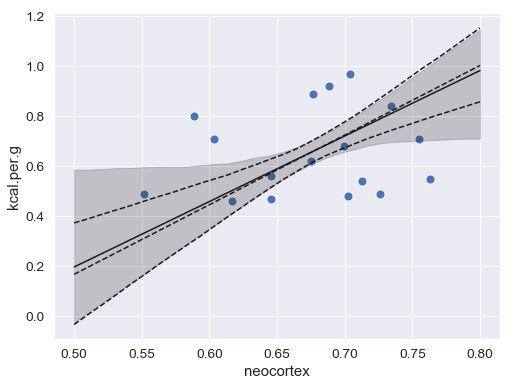

In [29]:
milk_ensemble = ensemble({"m6.11": m6_11, "m6.12": m6_12,
                          "m6.13": m6_13, "m6.14": m6_14}, data=d_predict)
mu = milk_ensemble["link"].mean(0)
mu_PI = stats.pi(milk_ensemble["link"], 0.89, dim=0)
sns.lineplot(nc_seq, mu, color="k", ax=ax)
ax.fill_between(nc_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
fig

### Code 6.31

In [30]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d["age"] = (d["age"] - d["age"].mean()) / d["age"].std()
torch.manual_seed(1000)
i = torch.multinomial(torch.ones(d.shape[0]), num_samples=(d.shape[0] // 2)).tolist()
d1 = d.iloc[i]
d2 = d.drop(index=i)